# 作业二：关联规则挖掘

## 一、问题描述

本作业选择数据集2：Wine Reviews作为对象，进行关联规则挖掘，主要任务包含：
    1.对数据集进行处理，转换成适合关联规则挖掘的形式；
    2.找出频繁项集；
    3.导出关联规则，计算其支持度和置信度;
    4.对规则进行评价，可使用Lift及其它指标, 要求至少2种；
    5.对挖掘结果进行可视化展示。

## 二、数据集描述

In [83]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
#数据集读取
wine_datas = ['data/d2/winemag-data_first150k.csv','data/d2/winemag-data-130k-v2.csv']
row_data = pd.read_csv(wine_datas[0])
row_data.rename(columns={'Unnamed: 0':'id'}, inplace = True)
#数据初步查看
row_data.head(5)

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [84]:
row_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
id             150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


本数据集共11个属性，其中一个id属性，两个数值属性。共150930条数据

## 三、关联规则挖掘 

### 3.1 将数据集转化成适合关联规则挖掘的形式 

由于问题复杂度和机器性能的限制，只取数据集的标称属性和评分points属性，并且去除空数据，8属性的列名分别为：country，designation，points，province，region_1，region_2，variety，winery

In [85]:
data = row_data.iloc[:,[1,3,4,6,7,8,9,10]]
data.head(5)

,country,designation,points,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,96,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,Carodorum Selección Especial Reserva,96,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Special Selected Late Harvest,96,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,96,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,La Brûlade,95,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [86]:
data = data.dropna(axis=0)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39427 entries, 0 to 150916
Data columns (total 8 columns):
country        39427 non-null object
designation    39427 non-null object
points         39427 non-null int64
province       39427 non-null object
region_1       39427 non-null object
region_2       39427 non-null object
variety        39427 non-null object
winery         39427 non-null object
dtypes: int64(1), object(7)
memory usage: 2.7+ MB


由于我们要对多个属性进行关联规则挖掘，属于多维关联分析问题，因此需要将不同属性的值转化为可生成频繁项集的形式。首先，将每个属性名：属性值的组合用一个二元组表示，
作为一个单项。

In [88]:
columns = []
for feature_name in data.columns:
    print("Dealing with feature: {}".format(feature_name))
    feature_col = data.loc[:,feature_name]
    columns.append(feature_col)
rows = list(zip(*columns))
#将数据转为数据字典存储
data_map = []
for data_line in rows:
    temp = []
    for i , value in enumerate(data_line):
        temp.append((data.columns[i], str(value)))
    data_map.append(temp)
print('data_map长度：',len(data_map))
print('首条数据：',data_map[0])

Dealing with feature: country
Dealing with feature: designation
Dealing with feature: points
Dealing with feature: province
Dealing with feature: region_1
Dealing with feature: region_2
Dealing with feature: variety
Dealing with feature: winery
data_map长度： 39427
首条数据： [('country', 'US'), ('designation', "Martha's Vineyard"), ('points', '96'), ('province', 'California'), ('region_1', 'Napa Valley'), ('region_2', 'Napa'), ('variety', 'Cabernet Sauvignon'), ('winery', 'Heitz')]


### 3.2 找出频繁项集

经过数据预处理，采用Apriori算法构建频繁项集。频繁项集（frequent item sets）是指支持度大于等于最小支持度(min_sup)的集合。其中支持度（support）是指某个集合在所有事务中出现的频率。将最小支持度定为0.05，最小置信度为0.5

Apriori算法首先会生成所有单个（属性名，属性值）的项集列表，然后扫描全部数据集来查看哪些项集满足最小支持度要求，其中不满足最小支持度的集合会被去掉，接着对剩下的集合进行组合（组合中要求属性名相同的项仅有一个）以生成包含两个项的项集，接着重新扫描交易记录，去掉不满足最小支持度的项集，该过程重复进行直到所有项集都被过滤掉。算法具体实现如下，细节见注释。

In [120]:
class Apriori(object):
    """
    分为两个步骤：
        1）找出所有频繁项集
        2）由频繁项集产生强关联规则
    """
    def __init__(self, min_support = 0.01, min_confidence = 0.5):
        self.min_support = min_support         # 最小支持度
        self.min_confidence = min_confidence   #  最小置信度

    def apriori(self, dataset):
        """
        Apriori算法实现
        :param dataset: 数据集，类型为一个list，list中每个元素是一个dict，key为属性名，value为对应属性的取值
        :return: 生成频繁项集
        """
        C1 = self.create_C1(dataset)
        dataset = [set(data) for data in dataset]
        L1, support_data = self.scan_D(dataset, C1)
        L = [L1]
        k = 2
        while len(L[k-2]) > 0:
            Ck = self.apriori_gen(L[k-2], k)
            Lk, support_k = self.scan_D(dataset, Ck)
            support_data.update(support_k)
            L.append(Lk)
            k += 1
        return L, support_data

    def create_C1(self, dataset):
        # 扫描dataset，构建全部可能的单元素候选项集合(list)
        # 每个单元素候选项：（属性名，属性取值）
        C1 = []
        for data in dataset:
            for item in data:
                if [item] not in C1:
                    C1.append([item])
        C1.sort()
        return [frozenset(item) for item in C1]

    def scan_D(self, dataset, Ck):
        # 过滤函数
        # 根据待选项集Ck的情况，判断数据集D中Ck元素的出现频率
        # 过滤掉低于最小支持度的项集
        Ck_count = dict()
        for data in dataset:
            for cand in Ck:
                if cand.issubset(data):
                    if cand not in Ck_count:
                        Ck_count[cand] = 1
                    else:
                        Ck_count[cand] += 1

        num_items = float(len(dataset))
        return_list = []
        support_data = dict()
        # 过滤非频繁项集
        for key in Ck_count:
            support  = Ck_count[key] / num_items
            if support >= self.min_support:
                return_list.insert(0, key)
            support_data[key] = support
        return return_list, support_data

    def apriori_gen(self, Lk, k):
        # 当待选项集不是单个元素时， 如k>=2的情况下，合并元素时容易出现重复
        # 因此针对包含k个元素的频繁项集，对比每个频繁项集第k-2位是否一致
        return_list = []
        len_Lk = len(Lk)

        for i in range(len_Lk):
            for j in range(i+1, len_Lk):
                # 第k-2个项相同时，将两个集合合并
                L1 = list(Lk[i])[:k-2]
                L2 = list(Lk[j])[:k-2]
                L1.sort()
                L2.sort()
                if L1 == L2:
                    return_list.append(Lk[i] | Lk[j])
        return return_list

    def generate_rules(self, L, support_data):
        """
        产生强关联规则算法实现
        基于Apriori算法，首先从一个频繁项集开始，接着创建一个规则列表，
        其中规则右部只包含一个元素，然后对这些规则进行测试。
        接下来合并所有的剩余规则列表来创建一个新的规则列表，
        其中规则右部包含两个元素。这种方法称作分级法。
        :param L: 频繁项集
        :param support_data: 频繁项集对应的支持度
        :return: 强关联规则列表
        """
        big_rules_list = []
        for i in range(1, len(L)):
            for freq_set in L[i]:
                H1 = [frozenset([item]) for item in freq_set]
                # 只获取有两个或更多元素的集合
                if i > 1:
                    self.rules_from_conseq(freq_set, H1, support_data, big_rules_list)
                else:
                    self.cal_conf(freq_set, H1, support_data, big_rules_list)
        return big_rules_list

    def rules_from_conseq(self, freq_set, H, support_data, big_rules_list):
        # H->出现在规则右部的元素列表
        m = len(H[0])
        if len(freq_set) > (m+1):
            Hmp1 = self.apriori_gen(H, m+1)
            Hmp1 = self.cal_conf(freq_set, Hmp1, support_data, big_rules_list)
            if len(Hmp1) > 1:
                self.rules_from_conseq(freq_set, Hmp1, support_data, big_rules_list)

    def cal_conf(self, freq_set, H, support_data, big_rules_list):
        # 评估生成的规则
        prunedH = []
        for conseq in H:
            sup = support_data[freq_set]
            conf = sup / support_data[freq_set - conseq]
            lift = conf / support_data[freq_set - conseq]
            if conf >= self.min_confidence:
                big_rules_list.append((freq_set-conseq, conseq, sup, conf, lift))
                prunedH.append(conseq)
        return prunedH


In [121]:
association = Apriori(0.05,0.5)
freq_set , support_data = association.apriori(data_map)
support_data_out = sorted(support_data.items(), key= lambda d:d[1],reverse=True)
print('频繁项集共有：',len(support_data_out),'条数据，输出前30条')
print('item\tsupport')
for key,value in support_data_out[:30]:
    print(list(key),'\t',value)

频繁项集共有： 15352 条数据，输出前30条
item	support
[('country', 'US')] 	 1.0
[('province', 'California')] 	 0.7273949324067264
[('province', 'California'), ('country', 'US')] 	 0.7273949324067264
[('region_2', 'Central Coast')] 	 0.23336799655058715
[('province', 'California'), ('region_2', 'Central Coast')] 	 0.23336799655058715
[('country', 'US'), ('region_2', 'Central Coast')] 	 0.23336799655058715
[('province', 'California'), ('country', 'US'), ('region_2', 'Central Coast')] 	 0.23336799655058715
[('region_2', 'Sonoma')] 	 0.19851878154564132
[('province', 'California'), ('region_2', 'Sonoma')] 	 0.19851878154564132
[('country', 'US'), ('region_2', 'Sonoma')] 	 0.19851878154564132
[('province', 'California'), ('country', 'US'), ('region_2', 'Sonoma')] 	 0.19851878154564132
[('variety', 'Pinot Noir')] 	 0.19032642605321226
[('country', 'US'), ('variety', 'Pinot Noir')] 	 0.19032642605321226
[('province', 'Washington')] 	 0.15651710756588125
[('country', 'US'), ('province', 'Washington')] 	 0.156

### 3.3 导出关联规则并计算支持度、置信度、Lift指标

In [124]:
# 获取强关联规则列表
big_rules_list = association.generate_rules(freq_set, support_data)
big_rules_list = sorted(big_rules_list, key= lambda x:x[3], reverse=True)
print('强关联规则：')
print('关联规则\t\t\t\t\t\t\t\t支持度，置信度，Lift')
for i in big_rules_list:
    print(i)

强关联规则：
关联规则								支持度，置信度，Lift
(frozenset({('points', '84')}), frozenset({('country', 'US')}), 0.06503157734547392, 1.0, 15.37714508580343)
(frozenset({('points', '85')}), frozenset({('country', 'US')}), 0.06807517690922464, 1.0, 14.689642324888228)
(frozenset({('points', '92')}), frozenset({('country', 'US')}), 0.08326781139828036, 1.0, 12.00944258300335)
(frozenset({('variety', 'Red Blend')}), frozenset({('country', 'US')}), 0.07515154589494509, 1.0, 13.306446169422882)
(frozenset({('points', '93')}), frozenset({('country', 'US')}), 0.05803129834884724, 1.0, 17.23208041958042)
(frozenset({('points', '87')}), frozenset({('country', 'US')}), 0.12554848200471758, 1.0, 7.965050505050505)
(frozenset({('points', '88')}), frozenset({('country', 'US')}), 0.10546072488396277, 1.0, 9.482202982202981)
(frozenset({('points', '89')}), frozenset({('country', 'US')}), 0.07591244578588277, 1.0, 13.173070497828267)
(frozenset({('variety', 'Zinfandel')}), frozenset({('country', 'US')}), 0.07139777309

根据挖掘到的关联规则，我们首先可以得到一些地理位置的归属。例如('province', 'Washington'),('country', 'US')这一条关联规则，说明华盛顿市属于美国，这也和我们的世界常识相符合，说明通过挖掘得到的关联规则是合理的。其他还有很多地区、省份、国家的关联规则被挖掘出来，例如Central Coast这个酒庄，通过规则我们可以确定它在美国的加利福尼亚州。通过variety这个属性相关的关联规则，我们可以发现Red Blend（血腥玛丽）和Zinfandel（木桥仙粉黛）两种酒主要产自美国。

### 3.4 关联规则可视化

首先将上文的关联规则转化成Pandas内置Dataframe数据结构，方便绘图

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

rules = []
for rule in big_rules_list:
    item = []
    begin = rule[0]
    end = rule[1]
    text1,text2  = '',''
    for i in begin:
        text1+=':'.join(list(i))+'.'
    for i in end:
        text2+=':'.join(list(i))+'.'
    item.append(text1+'-->'+text2)
    item.extend([rule[2],rule[3],int(rule[4])])
    rules.append(item)
rules = pd.DataFrame(rules,columns=['rule','support','confidence','lift'])

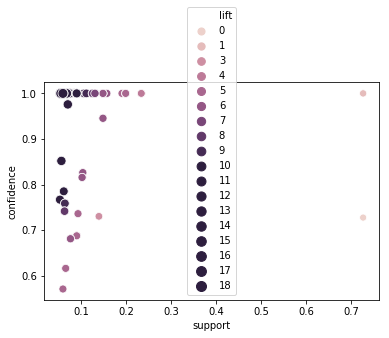

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="support", y="confidence",hue="lift", size="lift",sizes=(50, 100), hue_norm=(0, 10),legend="full", data=rules)

将规则的Lift值取整数，方便进行可视化。可以看出具有价值（Lift大于3）的关联规则其置信度都较高。